In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/AIH

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/AIH


In [3]:
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, dataset
import torchvision
from torchvision import transforms

In [4]:
trans = transforms.Compose([transforms.Resize((224, 224)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                            ])

trainset = torchvision.datasets.ImageFolder(root='./eczema', transform = trans)
#testset = torchvision.datasets.ImageFolder(root='./idenprof/test', transform = trans)

In [5]:
print("이미지 수: ", len(trainset))
print("class: ", trainset.classes)
classes = trainset.classes

이미지 수:  533
class:  ['eczema', 'normal']


In [8]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=4)
#testloader = DataLoader(testset, batch_size=256, shuffle=True, num_workers=4)

In [10]:
def imshow(img):
  img = img / 2 + 0.5
  np_img = img.numpy()
  plt.figure(figsize=(10,10))
  plt.imshow(np.transpose(np_img, (1, 2, 0)))
  print(np_img.shape)
  print((np.transpose(np_img, (1,2,0))).shape)

(3, 1810, 1810)
(1810, 1810, 3)


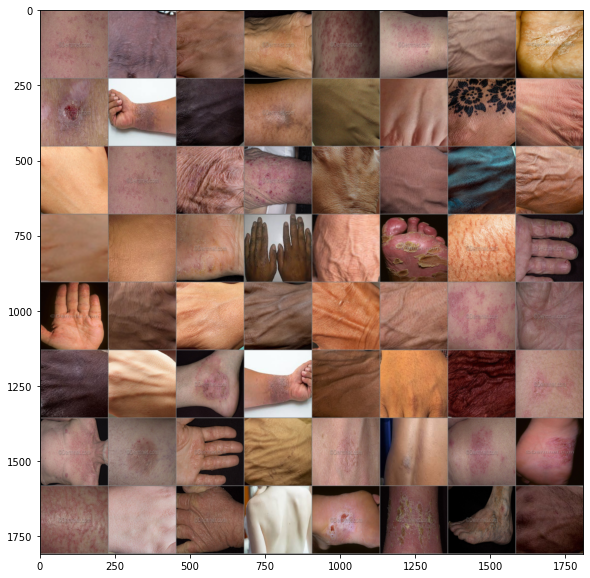

In [11]:
images, labels = next(iter(trainloader))
imshow(torchvision.utils.make_grid(images, nrow=8))

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [20]:
import torchvision.models as models
model = models.resnet18(pretrained = False)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

model = model.to(device)

In [21]:
from torchsummary import summary

summary(model, (3, 224, 224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [22]:
from torch import optim
from torch.optim.lr_scheduler import StepLR

num_epochs = 10
learning_rate = 0.001
loss_func = torch.nn.CrossEntropyLoss()
opt = optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
scheduler = optim.lr_scheduler.LambdaLR(optimizer=opt,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,)

In [24]:
def train(model, train_loader, optimizer, log_interval):
#    for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    run_cnt = 0
#    for data in tqdm(train_loader):
    for i, data in enumerate(train_loader):
        num_of_mini_batch = len(train_loader)
        inputs, gt = data
        inputs, gt = inputs.to(device), gt.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        
        _, preds = torch.max(outputs, 1)
#        print(gt.shape)
#        print(preds.shape)

        loss = loss_func(outputs, gt)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == gt.data)
        run_cnt += len(gt)
        
        if i % log_interval == 0:
            print("[{}/{}]({:.0f}%)   Train Loss : {:.6f} ".format(i*batch_size, 
                                                               len(train_loader.dataset),
                                                               100.*i / num_of_mini_batch,
                                                               loss.item()))
            #torch.save(model.state_dict(), './my_weights.pth')
        
    cost = running_loss / len(train_loader)
    acc = (running_corrects.double() / run_cnt)*100
    train_loss_list.append(cost)
    train_acc_list.append(acc)
    
    print('train loss: %.4f, train acc: %.4f' %(cost, acc))
    torch.save(model.state_dict(), './eczema_resnet_weights.pth')

In [25]:
train_loss_list = []
train_acc_list = []
batch_size = 64

for i in range(num_epochs):
    print("==================== EPOCH :  %d ===================="%i)
    #print('='*20,'EPOCH : ', i,'='*20)
    #print('-'*20,'TRAIN','-'*20)
    train(model, trainloader, opt, log_interval = 3)
    #print('-'*20,'TEST','-'*20)
#    test(model, test_loader, opt, logger)
    scheduler.step()

==================== EPOCH :  0 ====================
[0/533](0%)   Train Loss : 0.763452 
[192/533](33%)   Train Loss : 0.948289 
[384/533](67%)   Train Loss : 0.482407 
train loss: 0.8660, train acc: 63.4146
==================== EPOCH :  1 ====================
[0/533](0%)   Train Loss : 0.479588 
[192/533](33%)   Train Loss : 0.438413 
[384/533](67%)   Train Loss : 0.309297 
train loss: 0.4354, train acc: 81.0507
==================== EPOCH :  2 ====================
[0/533](0%)   Train Loss : 0.441771 
[192/533](33%)   Train Loss : 0.270757 
[384/533](67%)   Train Loss : 0.329190 
train loss: 0.3508, train acc: 85.1782
==================== EPOCH :  3 ====================
[0/533](0%)   Train Loss : 0.177012 
[192/533](33%)   Train Loss : 0.309051 
[384/533](67%)   Train Loss : 0.318870 
train loss: 0.2928, train acc: 86.4916
==================== EPOCH :  4 ====================
[0/533](0%)   Train Loss : 0.256692 
[192/533](33%)   Train Loss : 0.256772 
[384/533](67%)   Train Loss : 0.16

In [26]:
## CNN feature extraction

myset = torchvision.datasets.ImageFolder(root='./eczema/', transform = trans)
mysetloader = DataLoader(myset, batch_size=1, shuffle=False, num_workers=4)

In [27]:
import copy
my_model = copy.deepcopy(model)

In [28]:
for name, layer in enumerate(my_model.children()):
  print("#"*20)
  print("str(name): ", str(name))
  print("layer: ", layer)
  print("#"*20)

####################
str(name):  0
layer:  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
####################
####################
str(name):  1
layer:  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
####################
####################
str(name):  2
layer:  ReLU(inplace=True)
####################
####################
str(name):  3
layer:  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
####################
####################
str(name):  4
layer:  Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
 

In [29]:
def get_features(x, model, layers):
    features = {}
    for name, layer in enumerate(model.children()): # 0, conv
        #print("str(name): ", str(name))
        x = layer(x)
        if str(name) in layers:
          #print("들어왔다")
          features[layers[str(name)]] = x.tolist()
          return features
#    return features

In [30]:
feature_layers = {'8':'AdaptiveAvgPool2d'}
#feature_layers = {'6':'Sequential'}

In [31]:
cnn_features = []
for i, data in enumerate(mysetloader):
    num_of_mini_batch = len(mysetloader)
    inputs, gt = data
    inputs, gt = inputs.to(device), gt.to(device)
    
    #content_tensor = torch.randn(3,128,128)
    #con_tensor = content_tensor.unsqueeze(0).to(device) # 3,128,128
    cnn_feature = get_features(inputs, my_model, feature_layers)

    cnn_features.append(cnn_feature)

In [32]:
print(len(cnn_features))
print(cnn_features[0].keys())

533
dict_keys(['AdaptiveAvgPool2d'])


In [34]:
cnn_features_ndary = np.array(cnn_features)
print(cnn_features_ndary.shape)
print(len(cnn_features_ndary[0]['AdaptiveAvgPool2d']))

(533,)
1


In [35]:
import pandas as pd

In [36]:
allFiles, _ = map(list, zip(*mysetloader.dataset.samples))
file_pathss = []
for i, (inputs, labels) in enumerate(mysetloader):
  inputs = inputs.to(device)
    
  for j in range(inputs.size()[0]):
    #print(allFiles[ i * 1 + j ])
    file_pathss.append(allFiles[ i * 1 + j ])

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [37]:
my_df = pd.DataFrame(cnn_features)
my_df['file_paths'] = pd.DataFrame(file_pathss)
my_df

,AdaptiveAvgPool2d,file_paths
0,"[[[[1.078570008277893]], [[0.9516760110855103]...",./eczema/eczema/03DermatitisArm1.jpg
1,"[[[[1.0689826011657715]], [[0.8935964107513428...",./eczema/eczema/03DermatitisLeg.jpg
2,"[[[[0.9693131446838379]], [[0.7919498085975647...",./eczema/eczema/03Desquamation12341.jpg
3,"[[[[1.0386770963668823]], [[1.0289943218231201...",./eczema/eczema/03dermatitisDrug112205.jpg
4,"[[[[1.043393850326538]], [[0.8813031315803528]...",./eczema/eczema/03dermatitisDrug1122051.jpg
...,...,...
528,"[[[[1.0360465049743652]], [[0.9015323519706726...",./eczema/normal/normal107.png
529,"[[[[0.9800348877906799]], [[0.7682128548622131...",./eczema/normal/normal_skin_white176.jpg
530,"[[[[0.9785482287406921]], [[0.9571852087974548...",./eczema/normal/normal_skin_white4.jpg
531,"[[[[0.8763216733932495]], [[0.741810142993927]...",./eczema/normal/normal_skin_white79.jpg


In [38]:
my_df.to_csv('./eczema_968105_resnet18_extraction.csv', index=False)

Clustering

In [39]:
import pandas as pd
import numpy as np

In [ ]:
#df = copy.deepcopy(my_df)
%cd /content/drive/MyDrive/Colab Notebooks/AIH

/content/drive/MyDrive/Colab Notebooks/AIH


In [40]:
df = pd.read_csv('eczema_968105_resnet18_extraction.csv')

In [41]:
import copy
import warnings
warnings.filterwarnings("ignore")

In [42]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.cluster import DBSCAN

In [43]:
df = df.astype({'AdaptiveAvgPool2d':'object'})
df.dtypes
#A = np.array(df['AdaptiveAvgPool2d'][0].tolist())

AdaptiveAvgPool2d    object
file_paths           object
dtype: object

In [44]:
type(df['AdaptiveAvgPool2d'][0])

str

In [45]:
features = []
for i in range(len(df)):
  test = df['AdaptiveAvgPool2d'][i]
  exec('test='+test)
  temp = []
  for j in range(len(test[0])):
    temp.append(test[0][j][0][0])
  features.append(temp)

In [46]:
print(len(features))
print(len(features[0]))

533
512


In [47]:
my_features = copy.deepcopy(features)

In [48]:
print(len(my_features))
print(len(my_features[0]))

533
512


In [49]:
# PCA
from sklearn.decomposition import PCA

features = np.array(my_features)
pca = PCA(n_components=50)
pca.fit(my_features)
pca_features = pca.transform(my_features)

In [ ]:
pca_features.shape

(1800, 50)

In [71]:
X = np.array(pca_features[:261])
X = np.array(my_features[:261])

X.shape

(261, 512)

In [72]:
X

array([[1.07857001, 0.95167601, 1.00152349, ..., 0.80112189, 0.71614921,
        0.84568775],
       [1.0689826 , 0.89359641, 1.01501811, ..., 0.83894414, 0.69946569,
        0.85350424],
       [0.96931314, 0.79194981, 0.89655209, ..., 0.78647804, 0.64926732,
        0.70465457],
       ...,
       [1.04915798, 0.99834645, 1.01685739, ..., 0.83270681, 0.75561422,
        0.83603245],
       [0.97497618, 0.78862005, 0.96323687, ..., 0.8364048 , 0.65875918,
        0.83903182],
       [1.01955438, 0.94194514, 0.94324929, ..., 0.75992054, 0.66312051,
        0.75654691]])

In [73]:
for eps in [0.1, 0.5, 1, 1.5, 2, 2.5, 3]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(X)
    print("클러스터 수: {}".format(len(np.unique(labels))))
    print("클러스터 크기: {}".format(np.bincount(labels + 1)))


eps=0.1
클러스터 수: 1
클러스터 크기: [261]

eps=0.5
클러스터 수: 1
클러스터 크기: [261]

eps=1
클러스터 수: 3
클러스터 크기: [144 114   3]

eps=1.5
클러스터 수: 2
클러스터 크기: [ 34 227]

eps=2
클러스터 수: 1
클러스터 크기: [  0 261]

eps=2.5
클러스터 수: 1
클러스터 크기: [  0 261]

eps=3
클러스터 수: 1
클러스터 크기: [  0 261]


In [74]:
eps = 1.5
print("\neps={}".format(eps))
dbscan = DBSCAN(eps=eps, min_samples=3)
labels = dbscan.fit_predict(X)
print("클러스터 수: {}".format(len(np.unique(labels))))
print("클러스터 크기: {}".format(np.bincount(labels + 1)))
print(np.where(labels == -1))


eps=1.5
클러스터 수: 2
클러스터 크기: [ 34 227]
(array([  8,   9,  11,  15,  16,  19,  21,  22,  23,  24,  28,  29,  31,
        33,  36,  37,  39,  40,  41,  42,  44,  47,  48,  49,  50,  51,
        69, 116, 117, 118, 123, 130, 155, 156]),)


In [75]:
n_c = [2,3,4,5,6,7,8]
for n in n_c:
  agg = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
  assignment = agg.fit_predict(X)
  #print("cluster label: ", assignment)
  print("클러스터 크기: {}".format(np.bincount(assignment + 1)))

클러스터 크기: [  0 172  89]
클러스터 크기: [  0  89  55 117]
클러스터 크기: [  0  55  29 117  60]
클러스터 크기: [  0 117  29  24  60  31]
클러스터 크기: [ 0 86 29 24 60 31 31]
클러스터 크기: [ 0 29 45 24 60 31 31 41]
클러스터 크기: [ 0 24 45 41 60 31 31 26  3]


In [56]:
# Grad-CAM

In [57]:
# Grad-CAM
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import torch.nn.functional as F
from torch.utils.data import DataLoader, dataset
import torchvision

model = models.resnet18(pretrained = False)

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [58]:
df = pd.read_csv('eczema_968105_resnet18_extraction.csv')

In [59]:
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [62]:
from torchcam.methods import SmoothGradCAMpp
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

cam_extractor = SmoothGradCAMpp(model)

In [76]:
l = [8, 9, 11, 15, 16, 19, 21, 22, 23, 24, 28, 29, 31, 33, 36, 37, 39, 40, 41, 42, 44, 47, 48, 49, 50, 51, 69, 116, 117, 118, 123, 130, 155, 156]

In [77]:
f_paths = df['file_paths'].tolist()

In [78]:
import cv2
# torchvision.transforms.ToTensor
tf_toTensor = transforms.ToTensor() 

for i in l:
    f_paths[i]
    #img = Image.open(f_paths[i]).convert("RGB")
    img = cv2.imread(f_paths[i])

    input_tensor = tf_toTensor(img)
    input_tensor = input_tensor.to(device)

    out = model(input_tensor.unsqueeze(0))
    activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

    result = overlay_mask(to_pil_image(input_tensor), to_pil_image(activation_map[0], mode='F'), alpha=0.6)
    plt.imshow(result); plt.axis('off'); plt.show()

Output hidden; open in https://colab.research.google.com to view.